# Mira regnet

In [25]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch

import pyciemss
from pyciemss.PetriNetODE.interfaces import (setup_petri_model, reset_model, intervene_petri_model, intervene,
                                             sample_petri, calibrate_petri, optimize, load_petri_model)
from pyciemss.PetriNetODE.models import MiraRegNetODESystem, LotkaVolterra
import mira
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plotting utils

In [47]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population')
    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data.squeeze().detach().numpy(), color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

COLORS=['red','blue','green','black','gold', 'magenta', 'purple']

def plot_trajectories(sol, tspan, data=None):
    fig = plt.figure(facecolor='w', figsize=(6, 6))
    ax = fig.add_subplot(111, axisbelow=True) # setup graph
    d_keys = [list(x[1].keys())[0] for x in data] if data else [] # get affected variables
    torch_tspan = torch.as_tensor(tspan) # for use in multi-trajectory graph
    indices = torch.ones_like(tspan).bool()
    
    for i,var in enumerate([s for s in sol if '_sol' in s]): # skip beta, gamma parameters
        
        if len(sol[var]) == 1: # single trajectory, draw line
            ax.plot(tspan, sol[var].squeeze().detach().numpy(), COLORS[i], alpha=0.5, lw=3, label=var[:-4])
        
        else: # fill between multiple trajectories
            I_low = torch.quantile(sol[var], 0.05, dim=0).detach().numpy()
            I_up  = torch.quantile(sol[var], 0.95, dim=0).detach().numpy()
            ax.fill_between(torch_tspan, I_low, I_up,
                            alpha=0.2, color=COLORS[i], label=var[:-4])
        
        if var in d_keys: # plot training points of this variable
            x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
            y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
            ax.scatter(x,y,label=var[:-4]+" data",color=COLORS[i])
    
    ax.legend()
    return ax
    
def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='--', label=f'intervention at T={t}')

    return ax


## Petri utils

In [21]:
from pyciemss.interfaces import DynamicalSystem
def reparameterize(model: DynamicalSystem, parameters: dict) -> DynamicalSystem:
    """Intervenes on an initialized model to set the parameters as specified in the dictionary."""
    parameter_interventions = [ ((i+1)*1e-5, param, value) for i, (param, value) in enumerate(parameters.items())]
    return intervene(model, parameter_interventions)


# Deterministic Lotka Volterra

## Load model

In [22]:
from pyciemss.PetriNetODE.models import MiraRegNetODESystem
from pyciemss.PetriNetODE.base import get_name
import os
ASKENET_PATH = "../../test/models/may-hackathon"
filename = "lotka_volterra.json"
filename = os.path.join(ASKENET_PATH, filename)

raw_deterministic_lotka_volterra = MiraRegNetODESystem.from_askenet_regnet(filename)
raw_deterministic_lotka_volterra.G.variables['Rabbits'].data

{'name': 'Rabbits', 'identifiers': [], 'context': [], 'initial_value': None}

## Initialize model

In [33]:
start_state = dict(Rabbits=1.0, Wolves=1.0)
uncertain_lotka_volterra = setup_petri_model(raw_deterministic_lotka_volterra, start_time=0.0, start_state=start_state)
deterministic_lotka_volterra = reparameterize(uncertain_lotka_volterra, dict(alpha=0.67, beta=1.33, gamma=1.0, delta=1.0))

In [27]:
tspan = get_tspan(1, 50, 500)
def read_variables(variables):
    if variables is None:
        return ""
    else:
        return ",".join([v.data['name'] for v in variables if hasattr(v, 'data') and 'name' in v.data and v.data['name']])
def read_parameters(param):
    return param.value

## Sample trajectory

In [28]:
for key, transition in deterministic_lotka_volterra.G.transitions.items():
    print(key, f"rate: {read_parameters(transition.rate)}, control: {read_variables(transition.control)}, consumed: {read_variables(transition.consumed)}, produced: {read_variables(transition.produced)}")

('Rabbits', 'Rabbits', 'ControlledProduction') rate: Uniform(low: 0.6003000140190125, high: 0.7336999773979187), control: Rabbits, consumed: , produced: Rabbits
('Wolves', 'NaturalDegradation') rate: Uniform(low: 0.8999999761581421, high: 1.100000023841858), control: , consumed: Wolves, produced: 
('Rabbits', 'Wolves', 'ControlledDegradation') rate: Uniform(low: 1.1996999979019165, high: 1.4663000106811523), control: Wolves, consumed: Rabbits, produced: 
('Wolves', ('Rabbits', 'Wolves'), 'GroupedControlledProduction') rate: Uniform(low: 0.8999999761581421, high: 1.100000023841858), control: Rabbits,Wolves, consumed: , produced: Wolves


In [28]:
transition.produced

(<mira.modeling.Variable at 0x12c1874f0>,)

In [31]:
deterministic_lotka_volterra_trajectory = sample_petri(deterministic_lotka_volterra, tspan, 1)


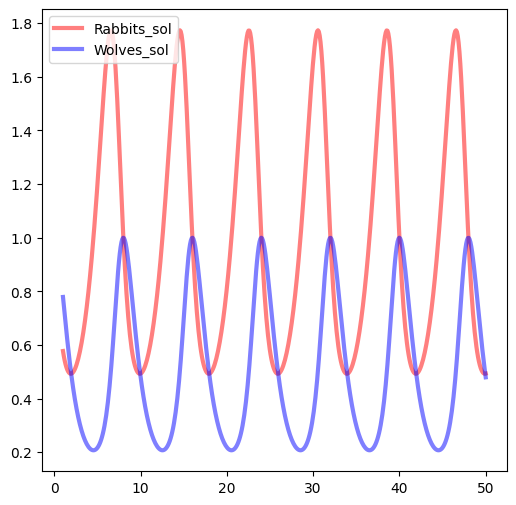

In [32]:
ax = plot_trajectories(deterministic_lotka_volterra_trajectory, tspan)


## Sample from prior

In [34]:

prior_samples = sample_petri(uncertain_lotka_volterra, tspan, 50)
prior_samples.keys()

dict_keys(['alpha', 'gamma', 'beta', 'delta', 'Rabbits_sol', 'Wolves_sol'])

<Axes: >

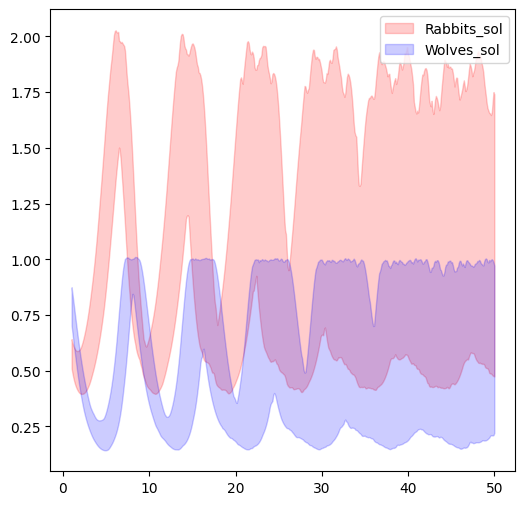

In [39]:
plot_trajectories(dict(Rabbits_sol= prior_samples['Rabbits_sol'], 
                       Wolves_sol= prior_samples['Wolves_sol']
                      ),tspan)

## Calibrate uncertain Lotka Volterra

We make one observation per day. Because we simulate 500 data points over 50 days, we need to sample every 10th timepoint.

In [41]:
fitted_parameters = calibrate_petri(uncertain_lotka_volterra, 
                                data =[(i, dict(Rabbits=deterministic_lotka_volterra_trajectory['Rabbits_sol'][0][i*10]))
                                       for i in range(1,50)])
fitted_parameters

AutoLowRankMultivariateNormal()

In [42]:
posterior_samples = sample_petri(uncertain_lotka_volterra, 
                                 timepoints=tspan, num_samples=50, 
                           inferred_parameters=fitted_parameters)
posterior_samples.keys()

dict_keys(['alpha', 'gamma', 'beta', 'delta', 'Rabbits_sol', 'Wolves_sol'])

<Axes: >

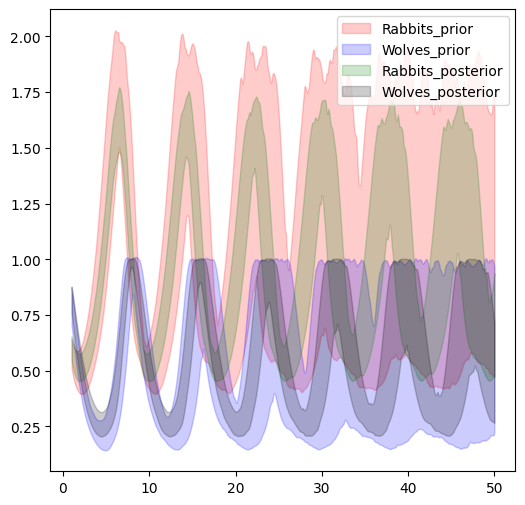

In [55]:
data =[(i, dict(Rabbits=deterministic_lotka_volterra_trajectory['Rabbits_sol'][0][i*10]))
                                       for i in range(1,50)]
plot_trajectories(dict(
        Rabbits_prior_sol= prior_samples['Rabbits_sol'], 
        Wolves_prior_sol= prior_samples['Wolves_sol'],
        Rabbits_posterior_sol= posterior_samples['Rabbits_sol'],
        Wolves_posterior_sol= posterior_samples['Wolves_sol'],
        Rabbits_data_sol= deterministic_lotka_volterra_trajectory['Rabbits_sol'],
    ),    
    tspan, data=data)

## Intervene on uncertain Lotka Volterra

In [53]:
intervened_lotka_volterra = intervene_petri_model(uncertain_lotka_volterra,
                                                  [(25, 'alpha', 1.0)])
intervened_lotka_volterra

MiraRegNetODESystem(
	alpha = Uniform(low: 0.6003000140190125, high: 0.7336999773979187),
	gamma = Uniform(low: 0.8999999761581421, high: 1.100000023841858),
	beta = Uniform(low: 1.1996999979019165, high: 1.4663000106811523),
	delta = Uniform(low: 0.8999999761581421, high: 1.100000023841858),
	pseudocount = 1
)

## Sample from intervened model

At $t=25$ we intervene to set $\alpha=1.0$.

In [54]:
intervened_samples = sample_petri(intervened_lotka_volterra,
                                  timepoints=tspan, num_samples = 50
                                  )
intervened_samples

{'alpha': tensor([0.6377, 0.6538, 0.6139, 0.6088, 0.6732, 0.6431, 0.6687, 0.7222, 0.6343,
         0.7288, 0.6210, 0.6985, 0.6030, 0.7147, 0.6546, 0.6953, 0.6997, 0.6105,
         0.6331, 0.6610, 0.6538, 0.6845, 0.6726, 0.6060, 0.7230, 0.6215, 0.6278,
         0.6706, 0.6118, 0.6694, 0.7050, 0.6740, 0.6501, 0.7256, 0.6707, 0.6351,
         0.7076, 0.6778, 0.7294, 0.6942, 0.6863, 0.6682, 0.6521, 0.6546, 0.6137,
         0.7144, 0.7297, 0.6536, 0.6960, 0.6161]),
 'gamma': tensor([1.0364, 0.9089, 1.0311, 1.0210, 1.0130, 0.9811, 1.0517, 1.0741, 1.0484,
         1.0362, 1.0606, 1.0793, 1.0688, 0.9585, 1.0573, 1.0138, 0.9975, 0.9105,
         1.0030, 0.9014, 1.0429, 1.0055, 1.0114, 1.0493, 1.0128, 0.9850, 0.9261,
         0.9758, 0.9103, 0.9426, 1.0362, 1.0377, 0.9116, 0.9949, 0.9763, 0.9683,
         0.9800, 1.0623, 1.0398, 0.9309, 0.9694, 0.9015, 1.0422, 0.9323, 1.0855,
         0.9646, 0.9893, 1.0715, 0.9654, 1.0655]),
 'beta': tensor([1.3521, 1.3042, 1.2436, 1.2233, 1.3339, 1.4071, 1.420

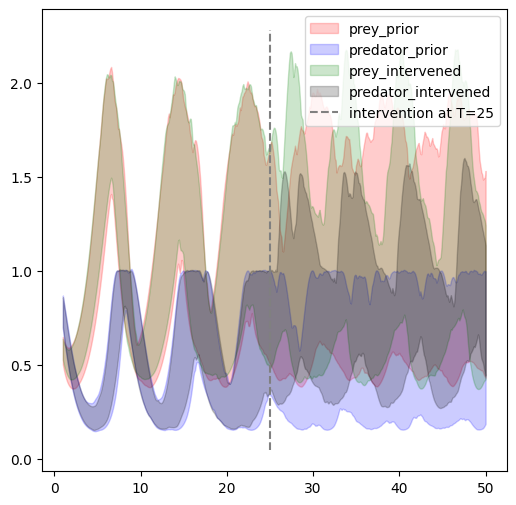

In [83]:

ax = plot_trajectories({
    'Rabbits_prior_sol': prior_samples['Rabbits_sol'], 
                  'Wolves_prior_sol': prior_samples['Wolves_sol'],
                  'Rabbits_intervened_sol': intervened_samples['Rabbits_sol'],
                 'Wolves_intervened_sol': intervened_samples['Wolves_sol'],
                  'Rabbits_data_sol': deterministic_lotka_volterra_trajectory['Rabbits_sol'],
                 # 'predator_data': deterministic_lotka_volterra_trajectory['predator_population_sol']
    },    tspan)
ax = plot_intervention_line(25, ax=ax)
ax.legend()

## Sample from counterfactual distribution

Given that we observe the deterministic trajectory in the factual world,
what would be the trajectory in a counterfactual world where we intervene at $t=25$ to set $\alpha=1.5$?

In [70]:
counterfactual_samples = sample_petri(intervened_lotka_volterra,
                                  timepoints=tspan, num_samples = 50,
                                      inferred_parameters=fitted_parameters
                                  )
counterfactual_samples

{'alpha': tensor([0.6621, 0.6667, 0.6625, 0.6708, 0.6567, 0.6691, 0.6667, 0.6665, 0.6665,
         0.6644, 0.6618, 0.6636, 0.6679, 0.6614, 0.6748, 0.6618, 0.6670, 0.6673,
         0.6673, 0.6640, 0.6730, 0.6695, 0.6759, 0.6662, 0.6616, 0.6599, 0.6650,
         0.6719, 0.6697, 0.6759, 0.6708, 0.6694, 0.6690, 0.6676, 0.6743, 0.6625,
         0.6660, 0.6579, 0.6671, 0.6667, 0.6705, 0.6688, 0.6681, 0.6599, 0.6568,
         0.6594, 0.6707, 0.6571, 0.6645, 0.6657]),
 'beta': tensor([1.2281, 1.2376, 1.2277, 1.2798, 1.2620, 1.2733, 1.2529, 1.2831, 1.2567,
         1.3006, 1.2802, 1.2963, 1.2575, 1.2314, 1.2800, 1.2633, 1.2622, 1.2592,
         1.2529, 1.2677, 1.2901, 1.2624, 1.2561, 1.2259, 1.2191, 1.2238, 1.2311,
         1.2420, 1.2371, 1.2800, 1.2522, 1.2555, 1.2385, 1.2674, 1.2478, 1.2415,
         1.2308, 1.2228, 1.2675, 1.2563, 1.2940, 1.2726, 1.2501, 1.2351, 1.2270,
         1.2282, 1.2446, 1.2598, 1.2339, 1.2340]),
 'gamma': tensor([1.0121, 1.0038, 1.0068, 1.0057, 1.0320, 1.0086, 1.001

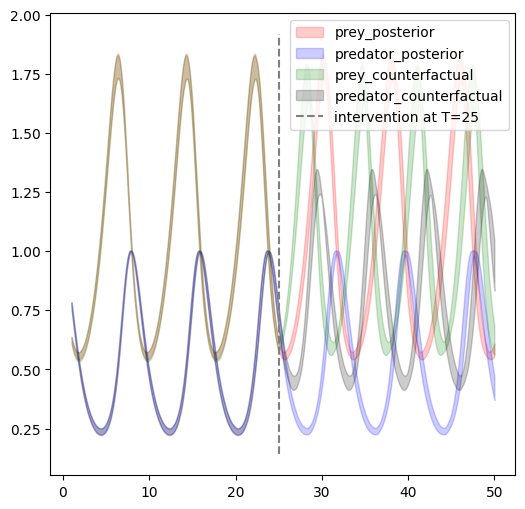

In [84]:
ax= plot_trajectories({
    'prey_posterior': posterior_samples['prey_population_sol'], 
                  'predator_posterior': posterior_samples['predator_population_sol'],
                  'prey_counterfactual': counterfactual_samples['prey_population_sol'],
                 'predator_counterfactual': counterfactual_samples['predator_population_sol'],
                 # 'prey_data': deterministic_lotka_volterra_trajectory['prey_population_sol'],
                 # 'predator_data': deterministic_lotka_volterra_trajectory['predator_population_sol']
    },    tspan)
ax = plot_intervention_line(25, ax)
ax.legend()